In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from DataReader import DataReader
import torch
import torch.nn as nn

In [3]:
# read data
dr = DataReader(val_size=0.1)
dr.read()
X_train, X_val, X_test, y_train, y_val = dr.data()

# X_train = np.concatenate((np.ones((X_train.shape[0],1),dtype=np.int64),X_train),axis=1)
# X_val = np.concatenate((np.ones((X_val.shape[0],1),dtype=np.int64),X_val),axis=1)
# X_test = np.concatenate((np.ones((X_test.shape[0],1),dtype=np.int64),X_test),axis=1)

X_train = torch.tensor(X_train,dtype=torch.float32)
y_train = torch.tensor(y_train,dtype=torch.float32)

X_val = torch.tensor(X_val,dtype=torch.float32)
y_val = torch.tensor(y_val,dtype=torch.float32)

X_test = torch.tensor(X_test,dtype=torch.float32)

In [20]:
X_train.shape,X_train[:5,:5]

(torch.Size([48830, 510]),
 tensor([[ 0.4927, -1.0007, -0.1820, -0.1781, -0.2538],
         [-0.2656,  0.9993, -0.1820, -0.1781, -0.2538],
         [-0.6989,  0.9993, -0.1820, -0.1781, -0.2538],
         [ 0.8177, -1.0007, -0.1820, -0.1781, -0.2538],
         [-0.3198,  0.9993, -0.1820, -0.1781, -0.2538]]))

In [52]:
class LogisticRegression(nn.Module):
    
    def __init__(self,n_input_features):
        super(LogisticRegression,self).__init__()
        self.Line = nn.Linear(n_input_features,1)
    
    def forward(self,X):
        return torch.sigmoid(self.Line(X))

In [103]:
model = LogisticRegression(X_train.shape[1])

loss_fn = nn.BCELoss()

model_pth = 'model.pth'

best_accuracy = 0

In [108]:
def train(decay):
    global best_accuracy
    optimizer = torch.optim.Adam(model.parameters(),lr=0.3,weight_decay=decay)
    
    epoches = 10000
    history = {
        'train loss':[],
        'val loss':[],
        'train acc':[],
        'val acc':[]
    }

    for epoch in range(epoches):
        y_pred = model(X_train)
        loss = loss_fn(y_pred,y_train)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        with torch.no_grad():
            y_pred_val = model(X_val)

            loss_val = loss_fn(y_pred_val,y_val)

            train_acc = (y_pred.round().eq(y_train).sum()/float(y_train.shape[0])).item()
            val_acc = (y_pred_val.round().eq(y_val).sum()/float(y_val.shape[0])).item()

            history['train acc'].append(train_acc)
            history['val acc'].append(val_acc)

            history['train loss'].append(loss.item())
            history['val loss'].append(loss_val.item())

            if val_acc > best_accuracy:
                print(f'better accuracy found:{val_acc} train acc:{train_acc} deacy:{decay}, model saved!')
                best_accuracy = val_acc
                torch.save(model.state_dict(),model_pth)

#         if (epoch+1) % (epoches/10) == 0:
#             print(f'epoch {epoch+1} train loss:{loss.item()} val loss:{loss_val.item()} train acc:{train_acc} val_acc:{val_acc}')


    plt.plot(range(epoches),history['train loss'],range(epoches),history['val loss'])
    plt.legend(['train','val'])
    plt.title('loss')
    plt.savefig(f'loss_{decay}.png')

    plt.figure()
    plt.plot(range(epoches),history['train acc'],range(epoches),history['val acc'])
    plt.legend(['train','val'])
    plt.title('accuracy')
    plt.savefig(f'acc_{decay}.png')

better accuracy found:0.6363803744316101 train acc:0.6836166381835938 deacy:0, model saved!
better accuracy found:0.6973829865455627 train acc:0.631619930267334 deacy:0, model saved!
better accuracy found:0.7882418036460876 train acc:0.6963956356048584 deacy:0, model saved!
better accuracy found:0.8357906341552734 train acc:0.7569936513900757 deacy:0, model saved!
better accuracy found:0.8442683219909668 train acc:0.8378455638885498 deacy:0, model saved!
better accuracy found:0.849797248840332 train acc:0.8277493119239807 deacy:0, model saved!
better accuracy found:0.8520088195800781 train acc:0.8506655693054199 deacy:0, model saved!
better accuracy found:0.8625138401985168 train acc:0.8544747233390808 deacy:0, model saved!
better accuracy found:0.8626981377601624 train acc:0.8678681254386902 deacy:0, model saved!
better accuracy found:0.8630667328834534 train acc:0.8677452206611633 deacy:0, model saved!
better accuracy found:0.8647254109382629 train acc:0.8702232241630554 deacy:0, mod

KeyboardInterrupt: 

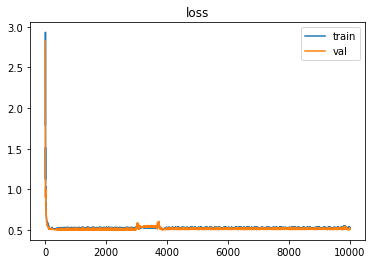

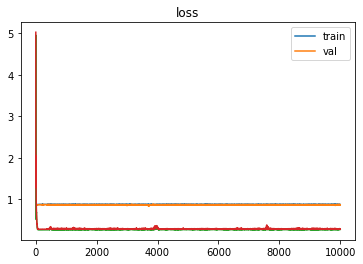

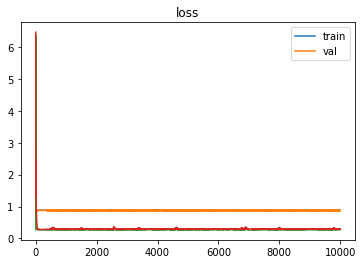

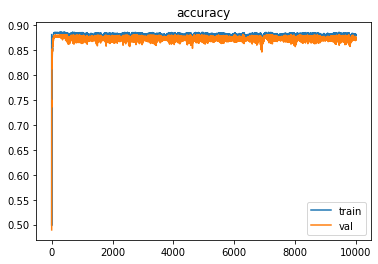

In [109]:
decays = [0,0.001,0.003,0.01,0.03,0.1,0.3,1]
for d in decays:
    train(d)

In [96]:
model.load_state_dict(torch.load(model_pth))

<All keys matched successfully>

In [97]:
with torch.no_grad():
    p = np.round(model(X_test).detach()).numpy().astype(np.int)

    import pandas as pd
    df = pd.DataFrame({'id':list(range(X_test.shape[0])),
                       'label':p.flatten()})

    df.to_csv('result.csv',index=None)

In [98]:
theta = np.abs(list(model.parameters())[0].detach().numpy()).flatten()

In [99]:
ind = np.argsort(theta)[::-1]

In [100]:
for i in ind[0:10]:
    print(f'{dr.columns[i]}\t{theta[i]}')

capital gains	0.8868908286094666
weeks worked in year	0.5790798664093018
dividends from stocks	0.5659188032150269
age	0.45645272731781006
 Trinadad&Tobago.2	0.3527606725692749
num persons worked for employer	0.3379727900028229
 Masters degree(MA MS MEng MEd MSW MBA)	0.30041295289993286
 Female	0.25408831238746643
 Male	0.25408828258514404
 Trinadad&Tobago	0.22973871231079102
